# HAM 10000

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow

from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.python.keras.applications import InceptionV3
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from IPython.display import Image

import shutil

In [2]:
meta_path = '../data/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'
image_path = '../data/skin-cancer-mnist-ham10000/images' # part 1 & 2
input_path = '../data/skin-cancer-mnist-ham10000/input' # train, val, test

meta = pd.read_csv(meta_path)

In [4]:
%%bash -s "$input_path"
# echo "Droping input folder $1"
# rm -r $1
echo "Creating input folders:"
mkdir -p $1/train/{nv,bkl,mel,bcc,akiec,vasc,df}
mkdir -p $1/test/{nv,bkl,mel,bcc,akiec,vasc,df}
mkdir -p $1/val/{nv,bkl,mel,bcc,akiec,vasc,df}
ls $1

Creating input folders:
test
train
val


## Overview

In [5]:
meta.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


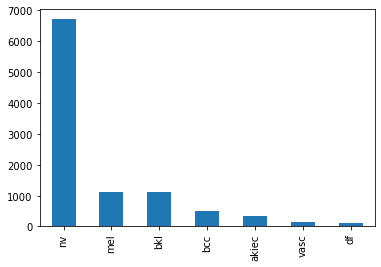

In [7]:
meta.dx.value_counts().plot(kind='bar')

## Data Preparation

### Remove duplicates

In [8]:
meta = meta.groupby('lesion_id').nth(0).reset_index()
meta.dx.value_counts()

nv       5403
bkl       727
mel       614
bcc       327
akiec     228
vasc       98
df         73
Name: dx, dtype: int64

### Downsample `nv` and `bkl`

In [9]:
# Optional step

dx_counts = meta.dx.value_counts()

del_meta_nv = meta[meta.dx == 'nv'].sample(n=dx_counts['nv']-dx_counts['mel']).index
del_meta_bkl = meta[meta.dx == 'bkl'].sample(n=dx_counts['bkl']-dx_counts['mel']).index

meta = meta.loc[~meta.index.isin(del_meta_nv)]
meta = meta.loc[~meta.index.isin(del_meta_bkl)]

meta.dx.value_counts()

bkl      614
mel      614
nv       614
bcc      327
akiec    228
vasc      98
df        73
Name: dx, dtype: int64

### Train/val/test split

In [10]:
train, Test = train_test_split(meta, stratify=meta.dx, test_size=0.2)
val, test = train_test_split(Test, stratify=Test.dx, test_size=0.1)

print(train.shape, val.shape, test.shape)

(2054, 7) (462, 7) (52, 7)


### Copy images to `input` folder

In [14]:
def copy_images(df, df_name):
    print('Copying {} images to {} folder'.format(len(df), df_name))
    for _, row in df.iterrows():
        src = '{}/{}.jpg'.format(image_path, row.image_id)
        dest = '{}/{}/{}/'.format(input_path, df_name, row.dx)
        # print('Copying {} to {}'.format(src, dest))
        shutil.copy2(src, dest)

copy_images(train, 'train')
copy_images(val, 'val')
copy_images(test, 'test')

Copying 2054 images to train folder
Copying 462 images to val folder
Copying 52 images to test folder


### Data Augmentation

In [26]:
data_gen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [27]:
train_batch_size = 32
train_gen = data_gen.flow_from_directory(
    '{}/train'.format(input_path),
    target_size=(224,224),
    color_mode="rgb",
    batch_size=train_batch_size,
    class_mode="categorical"
)

val_batch_size = 32
val_gen = data_gen.flow_from_directory(
    '{}/val'.format(input_path),
    target_size=(224,224),
    color_mode="rgb",
    batch_size=val_batch_size,
    class_mode="categorical"
)

test_gen = data_gen.flow_from_directory(
    '{}/test'.format(input_path),
    target_size=(224,224),
    color_mode="rgb",
    batch_size=1,
    shuffle=False,
    class_mode="categorical"
)

Found 2054 images belonging to 7 classes.
Found 421 images belonging to 7 classes.
Found 52 images belonging to 7 classes.


## MobileNet

In [28]:
mobile = MobileNet()

x = mobile.layers[-6].output
predictions = Dense(7, activation='softmax')(x) # 7 classes

model = Model(inputs=mobile.input, outputs=predictions)

for layer in model.layers[:-23]: # train last `n` layers
    layer.trainable = False

model.compile(optimizer=Adam(lr=.01), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit_generator(
    train_gen,
    epochs=10,
    steps_per_epoch=train_gen.n//train_gen.batch_size, 
    validation_data=val_gen,
    validation_steps=val_gen.n//val_gen.batch_size,
    verbose=2
)